In [1]:
import os

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns


Bad key "text.kerning_factor" on line 4 in
C:\Users\chan\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
# Import
# ======

# essential libraries
import math
import random
from datetime import timedelta

# storing and anaysis
import numpy as np
import pandas as pd

# visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objs as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
import calmap # 설치
import folium # 설치

# color pallette
cnf, dth, rec, act = '#393e46', '#ff2e63', '#21bf73', '#fe9801' 

# converter
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()   

# hide warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
# for offline ploting
# ===================
from plotly.offline import plot, iplot, init_notebook_mode
init_notebook_mode(connected=True)

In [4]:
path = '../covid'

In [5]:
os.chdir('data')
os.getcwd()

'C:\\Users\\chan\\Desktop\\covid\\data'

In [6]:
file_name_list = os.listdir()
file_name_list

['Case.csv',
 'PatientInfo.csv',
 'PatientRoute.csv',
 'Region.csv',
 'SearchTrend.csv',
 'SeoulFloating.csv',
 'Time.csv',
 'TimeAge.csv',
 'TimeGender.csv',
 'TimeProvince.csv',
 'Weather.csv']

In [7]:
time = pd.read_csv('Time.csv')

In [8]:
time.head()

,date,time,test,negative,confirmed,released,deceased
0,2020-01-20,16,1,0,1,0,0
1,2020-01-21,16,1,0,1,0,0
2,2020-01-22,16,4,3,1,0,0
3,2020-01-23,16,22,21,1,0,0
4,2020-01-24,16,27,25,2,0,0


<Figure size 576x360 with 0 Axes>

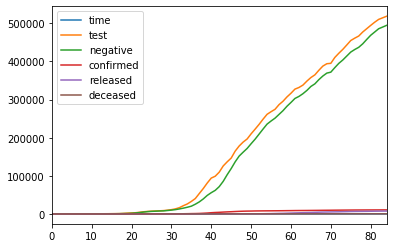

In [9]:
fig = plt.figure(figsize=(8,5))
fig.suptitle('Time')
time.plot()
plt.legend()
plt.show()

<Figure size 576x360 with 0 Axes>

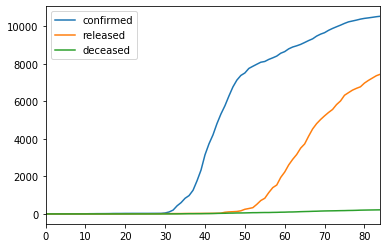

In [10]:
fig = plt.figure(figsize=(8,5))
fig.suptitle('Time')
time[['confirmed','released','deceased']].plot()
plt.legend()
plt.show()

다른 시각화 라이브러리

In [11]:
time.columns

Index(['date', 'time', 'test', 'negative', 'confirmed', 'released',
       'deceased'],
      dtype='object')

In [12]:
fig_1 = px.line(time, x='date', y='negative', color_discrete_sequence=[dth])
fig_2 = px.line(time, x='date', y='test', color_discrete_sequence=[rec])
fig = make_subplots(rows=1, cols=1, shared_xaxes=True)
fig.add_trace(fig_1['data'][0])
fig.add_trace(fig_2['data'][0])
fig.show()

In [13]:
time.columns

Index(['date', 'time', 'test', 'negative', 'confirmed', 'released',
       'deceased'],
      dtype='object')

In [14]:
fig = px.scatter(time, x='date', y='confirmed', title='Time Series with Confirmed')
fig.update_xaxes(rangeslider_visible=True)

fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=1, label="1m", step="month", stepmode="backward"),
            dict(count=2, label="2m", step="month", stepmode="backward"),
            dict(count=3, label="3m", step="month", stepmode="backward"),
            dict(count=1, label="YTD", step="year", stepmode="backward"),
            dict(step="all")
        ])
    )
)
fig.show()

In [15]:
import plotly.graph_objects as go
import numpy as np

# Create figure
fig = go.Figure()

# Add traces, one for each slider step
for step in np.arange(0, 5, 0.1):
    fig.add_trace(
        go.Scatter(
            visible=False,
            line=dict(color="#00CED1", width=6),
            name="𝜈 = " + str(step),
            x=time.date,
            y=time.confirmed))

# Make 10th trace visible
fig.data[10].visible = True

# Create and add slider
steps = []
for i in range(len(fig.data)):
    step = dict(
        method="restyle",
        args=["visible", [False] * len(fig.data)],
    )
    step["args"][1][i] = True  # Toggle i'th trace to "visible"
    steps.append(step)

sliders = [dict(
    active=10,
    currentvalue={"prefix": "Frequency: "},
    pad={"t": 50},
    steps=steps
)]

fig.update_layout(
    sliders=sliders
)

fig.show()

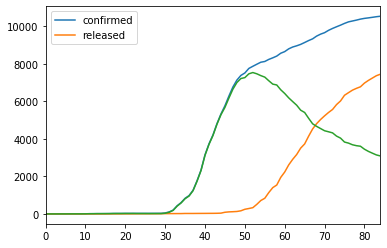

In [23]:
time[['confirmed','released']].plot()
(time['confirmed']-time['released']).plot()

확진자가 급속하게 먼저 늘어나고 이후 완치된 사람들이 늘어감
확진자 증가 속도가 감소하면서 전체적인 숫자가 줄어드는 것을 확인할 수 있음

In [25]:
time

,date,time,test,negative,confirmed,released,deceased
0,2020-01-20,16,1,0,1,0,0
1,2020-01-21,16,1,0,1,0,0
2,2020-01-22,16,4,3,1,0,0
3,2020-01-23,16,22,21,1,0,0
4,2020-01-24,16,27,25,2,0,0
...,...,...,...,...,...,...,...
80,2020-04-09,0,494711,468779,10423,6973,204
81,2020-04-10,0,503051,477303,10450,7117,208
82,2020-04-11,0,510479,485929,10480,7243,211
83,2020-04-12,0,514621,490321,10512,7368,214


In [28]:
timeAge = pd.read_csv('timeAge.csv')
timeAge

,date,time,age,confirmed,deceased
0,2020-03-02,0,0s,32,0
1,2020-03-02,0,10s,169,0
2,2020-03-02,0,20s,1235,0
3,2020-03-02,0,30s,506,1
4,2020-03-02,0,40s,633,1
...,...,...,...,...,...
382,2020-04-13,0,40s,1401,3
383,2020-04-13,0,50s,1932,14
384,2020-04-13,0,60s,1335,32
385,2020-04-13,0,70s,698,64


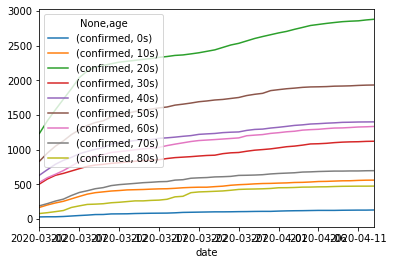

In [59]:
timeAge.pivot_table(index = ['date'],columns=['age'], aggfunc=sum).head()

table = timeAge.pivot_table(index = ['date'],columns=['age'], aggfunc=sum)
table[['confirmed']].plot()

의외로 확진자는 20대가 많다는 것을 볼 수 있음

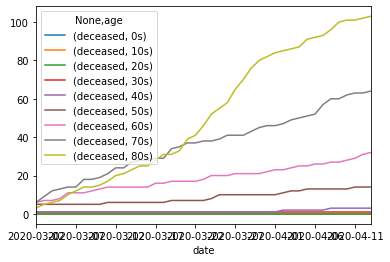

In [61]:
table[['deceased']].plot()

나이가 많을 수록 사망자 수가 매우 높음
> 20대가 확진자 수가 월등히 많음에도 사망자 숫자 자체가 80, 70대에서 더 많은 것은
> 나이에 따른 사망확률이 매우 높음을 알 수 있다.

In [62]:
timeAge

,date,time,age,confirmed,deceased
0,2020-03-02,0,0s,32,0
1,2020-03-02,0,10s,169,0
2,2020-03-02,0,20s,1235,0
3,2020-03-02,0,30s,506,1
4,2020-03-02,0,40s,633,1
...,...,...,...,...,...
382,2020-04-13,0,40s,1401,3
383,2020-04-13,0,50s,1932,14
384,2020-04-13,0,60s,1335,32
385,2020-04-13,0,70s,698,64
